In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Set it to your desired number of threads
import missingno as msno

from IPython.display import display #To display dataframe with a nice format.

# Setting display precision for pandas
pd.set_option("display.precision", 2)
# Set display option to show all columns
pd.set_option('display.max_columns', None)

blue_green      = (82/255, 162/255, 160/255)
blue_green_dark = (41/255, 81/255, 81/255)

# ==================================================================================================
# Set the fontsize & Bold for each GRAPH !!!
# ==================================================================================================
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 10
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams['axes.titlepad'] = 20 

In [2]:
# ==================================================================================================
# READ DATA
# ==================================================================================================
import csv
url_df_data               = r"C:\Users\Olivi\OneDrive\Documents\OC_Formation_DATA_SCIENCE\PROJET6_Classifiez_automatiquement_des_biens_de_consommation\DATA\Flipkart\flipkart_com-ecommerce_sample_1050.csv"
df_data = pd.read_csv(url_df_data)

print("Datasets loaded succesfully ! :D")

Datasets loaded succesfully ! :D


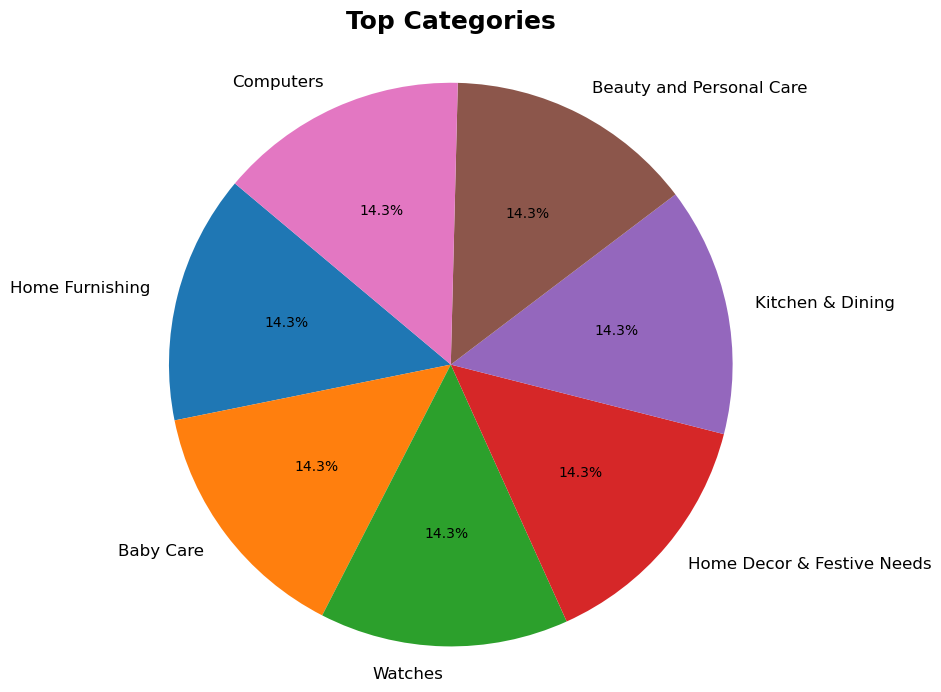

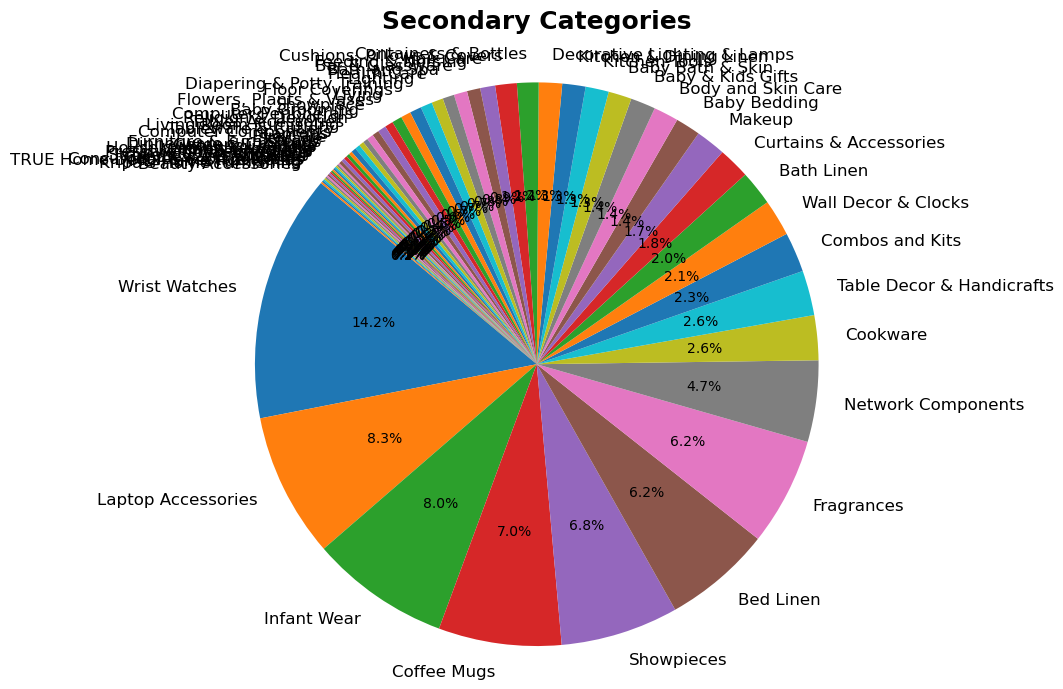

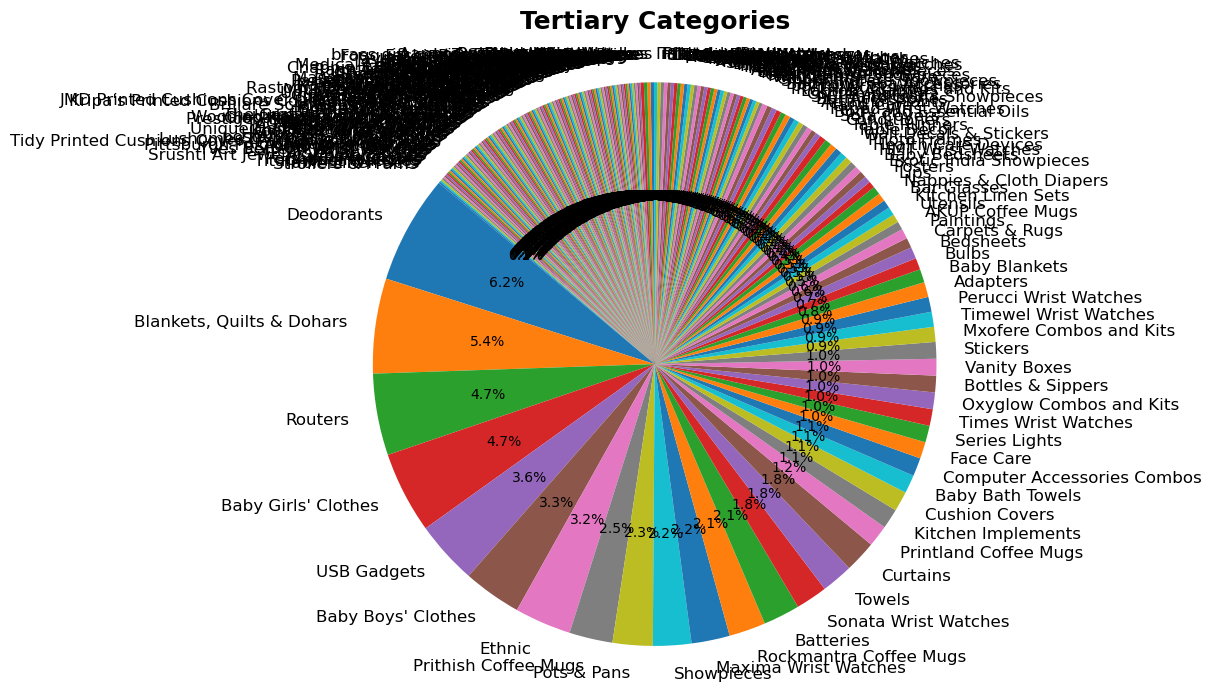

Number of unique top categories: 7
Number of unique secondary categories: 62
Number of unique tertiary categories: 241


In [3]:
# ==================================================================================================
# TRUE LABELS
# TOP, SECONDARY and TERTIARY CATEGORIES
# ==================================================================================================
# Function to extract top, secondary, and tertiary categories
def extract_categories(category_tree):
    # Split the category tree string and get categories
    categories = category_tree.strip('[]').split(">>")
    
    # Extract top category
    top_category = categories[0].strip().replace('"', '')
    
    # Extract secondary category if available
    secondary_category = categories[1].strip().replace('"', '') if len(categories) > 1 else None
    
    # Extract tertiary category if available
    tertiary_category = categories[2].strip().replace('"', '') if len(categories) > 2 else None
    
    return top_category, secondary_category, tertiary_category

# Apply the function to each row in the DataFrame
df_data['top_category'], df_data['secondary_category'], df_data['tertiary_category'] = zip(*df_data['product_category_tree'].apply(extract_categories))

# Extract unique categories
unique_top_categories = df_data['top_category'].unique()
unique_secondary_categories = df_data['secondary_category'].unique()
unique_tertiary_categories = df_data['tertiary_category'].unique()

# Function to plot pie chart for category distribution
def plot_category_pie_chart(categories, title):
    # Count the frequency of each category
    category_counts = categories.value_counts()
    
    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()

# Plot pie chart for top categories
plot_category_pie_chart(df_data['top_category'], 'Top Categories')

# Plot pie chart for secondary categories
plot_category_pie_chart(df_data['secondary_category'], 'Secondary Categories')

# Plot pie chart for tertiary categories
plot_category_pie_chart(df_data['tertiary_category'], 'Tertiary Categories')



# ==================================================================================================
# COUNT NUMBER OF CATEGORY IN TOP, SECONDARY and TERTIARY
# ==================================================================================================
# Extract unique categories
nunique_top_categories = df_data['top_category'].nunique()
nunique_secondary_categories = df_data['secondary_category'].nunique()
nunique_tertiary_categories = df_data['tertiary_category'].nunique()

print("Number of unique top categories:", nunique_top_categories)
print("Number of unique secondary categories:", nunique_secondary_categories)
print("Number of unique tertiary categories:", nunique_tertiary_categories)

# IMPTUE TERTIARY CATEGORY
df_data['tertiary_category'].fillna("NO TERTIARY CATEGORY", inplace=True)

In [4]:
category_counts = df_data['top_category'].value_counts()
category_counts_df = category_counts.to_frame().reset_index()
category_counts_df.columns = ['Category', 'Count']
display(category_counts_df)


,Category,Count
0,Home Furnishing,150
1,Baby Care,150
2,Watches,150
3,Home Decor & Festive Needs,150
4,Kitchen & Dining,150
5,Beauty and Personal Care,150
6,Computers,150


# PHOTO PREPROCESSING TEST

In [5]:
# ==================================================================================================
# CASE N PHOTOS
# ==================================================================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Step 1: Image Preprocessing
def preprocess_image(image, method='otsu', target_size=None, equalize_hist=False):
    # Resize image while preserving aspect ratio
    if target_size is not None:
        # Calculate aspect ratio of the original image
        original_height, original_width = image.shape[:2]
        aspect_ratio = original_width / original_height
        
        # Determine the dimension to resize based on the aspect ratio
        target_width, target_height = target_size
        if target_width / target_height > aspect_ratio:
            new_width = int(target_height * aspect_ratio)
            new_height = target_height
        else:
            new_width = target_width
            new_height = int(target_width / aspect_ratio)
        
        # Resize the image
        image = cv2.resize(image, (new_width, new_height))
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Equalize histogram if specified
    if equalize_hist:
        gray_image = cv2.equalizeHist(gray_image)
    
    # blurred_image = cv2.GaussianBlur(gray_image, (7, 7), 0)
    
    # if method == 'otsu':
    #     _, processed_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # elif method == 'adaptive':
    #     processed_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
    # elif method == 'canny':
    #     processed_image = cv2.Canny(blurred_image, 30, 150)
    # else:
    #     raise ValueError("Invalid method. Choose 'otsu', 'adaptive', or 'canny'.")
    
    processed_image = gray_image
    return processed_image



# Step 2: Feature Extraction
def extract_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

# I. BASIC FEATURE EXTRACTION

## I.1. CREATING A REPRESENTATIVE SAMPLES OF THE DISTRIBUTION OF THE POPULATION

In [6]:
# ==================================================================================================
# Create a representive samples of the population
# ==================================================================================================
import os
import random

# Load image paths and their corresponding categories
folder_path = r"C:\Users\Olivi\OneDrive\Documents\OC_Formation_DATA_SCIENCE\PROJET6_Classifiez_automatiquement_des_biens_de_consommation\DATA\Flipkart\Images"
image_files = os.listdir(folder_path)
image_paths = [os.path.join(folder_path, image_file) for image_file in image_files]

# Define the number of images to sample from each category
sample_size_per_category = 150 #max : 150

# Initialize lists to store selected image paths and their corresponding labels
selected_image_paths = []
image_labels = []

# Iterate over each image category
for category in df_data['top_category'].unique():
    # Filter image paths for the current category
    category_image_paths = [image_path for image_path in image_paths if image_path.split(os.sep)[-1].split('.')[0] in df_data[df_data['top_category'] == category]['uniq_id'].values]
    
    # If the number of images in the category is less than the sample size, use all images
    if len(category_image_paths) <= sample_size_per_category:
        selected_image_paths.extend(category_image_paths)
    else:
        # Randomly sample images from the category
        selected_image_paths.extend(random.sample(category_image_paths, sample_size_per_category))
    
    # Add corresponding labels
    image_labels.extend([category] * sample_size_per_category)

# Count the number of unique categories used when selecting the photos
unique_categories_selected = len(set(image_labels))
print("Number of unique categories selected:", unique_categories_selected)

Number of unique categories selected: 7


In [7]:
# ==================================================================================================
# Create a new set of photos (rotated and scaled)
# ==================================================================================================
import cv2
import os

# Function to rotate image by a given angle
def rotate_image(image, angle):
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (cols, rows))
    return rotated_image

def zoom_image(image, zoom_factor):
    """
    Zoom in or out on the center of the image.

    Parameters:
        image (numpy.ndarray): Input image.
        zoom_factor (float): Zoom factor. Values greater than 1 zoom in, values less than 1 zoom out.

    Returns:
        numpy.ndarray: Zoomed image.
    """
    # Get image dimensions
    height, width = image.shape[:2]

    # Calculate the new dimensions based on the zoom factor
    new_height = int(height / zoom_factor)
    new_width = int(width / zoom_factor)

    # Calculate the region of interest (ROI) in the original image
    start_y = max(0, int((height - new_height) / 2))
    end_y = min(height, start_y + new_height)
    start_x = max(0, int((width - new_width) / 2))
    end_x = min(width, start_x + new_width)

    # Extract the ROI from the original image
    roi = image[start_y:end_y, start_x:end_x]

    # Resize the ROI to the original image dimensions
    zoomed_image = cv2.resize(roi, (width, height), interpolation=cv2.INTER_LINEAR)

    return zoomed_image

# Function to flip image horizontally
def flip_horizontal(image):
    flipped_image = cv2.flip(image, 1)
    return flipped_image

# Function to flip image vertically
def flip_vertical(image):
    flipped_image = cv2.flip(image, 0)
    return flipped_image

# Function to adjust brightness of image
def adjust_brightness(image, brightness_factor):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * brightness_factor, 0, 255)
    brightened_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return brightened_image

# Function to adjust contrast of image
def adjust_contrast(image, contrast_factor):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab[:, :, 1] = np.clip(lab[:, :, 1] * contrast_factor, 0, 255)
    contrasted_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return contrasted_image

# Function to randomly crop image
def random_crop(image, crop_size):
    height, width = image.shape[:2]
    x = random.randint(0, width - crop_size)
    y = random.randint(0, height - crop_size)
    cropped_image = image[y:y+crop_size, x:x+crop_size]
    return cropped_image






# Define the directory to save augmented images
output_dir = r"C:\Users\Olivi\OneDrive\Documents\OC_Formation_DATA_SCIENCE\PROJET6_Classifiez_automatiquement_des_biens_de_consommation\DATA\Flipkart\Images_scaled_rotated"

# Ensure the output directory exists, otherwise create it
os.makedirs(output_dir, exist_ok=True)


# Create an empty list to store the augmented data
augmented_data = []

# Define the number of rotation steps and scale steps
rotation_steps = 3
scale_steps = 3
# brightness_factors = [0.8, 1.0, 1.2]
# contrast_factors = [0.8, 1.0, 1.2]

# Iterate over selected image paths and augment each image
for idx, image_path in enumerate(selected_image_paths):
    image_name = os.path.basename(image_path)
    image_name = os.path.splitext(image_name)[0]

    image = cv2.imread(image_path)
    cntZoom = 0
    # Rotate the image by different angles
    for rotation_step in range(rotation_steps):
        angle = 360 / rotation_steps * rotation_step
        rotated_image = rotate_image(image, angle)
        cv2.imwrite(os.path.join(output_dir, f"{image_name}_rotated_{int(angle)}_{idx}.jpg"), rotated_image)
        
        rotated_filename = f"{image_name}_rotated_{angle}_{idx}.jpg"
        curr_image_row = df_data[df_data['uniq_id'] == image_name]
        curr_image_row['uniq_id'] = f"{image_name}_rotated_{int(angle)}_{idx}"
        augmented_data.append(curr_image_row)

    
    # Scale the image by zooming in or out
    for scale_step in range(scale_steps):
        cntZoom = cntZoom + 1
        zoom_factor = 1 + 0.1 * scale_step  # Zoom factors from 1.0 to 1.4
        zoomed_image = zoom_image(image, zoom_factor)
        cv2.imwrite(os.path.join(output_dir, f"{image_name}_zoomed_{int(zoom_factor)+cntZoom}_{idx}.jpg"), zoomed_image)

        zoomed_filename = f"{image_name}_zoomed_{int(zoom_factor)+cntZoom}_{idx}.jpg"
        curr_image_row = df_data[df_data['uniq_id'] == image_name]
        curr_image_row['uniq_id'] = f"{image_name}_zoomed_{int(zoom_factor)+cntZoom}_{idx}"
        augmented_data.append(curr_image_row)

    # # Brightness adjustment
    # for brightness_factor in brightness_factors:
    #     brightened_image = adjust_brightness(rotated_image, brightness_factor)
    #     brightened_filename = f"{image_name}_brightened_{brightness_factor}_{idx}.jpg"
    #     cv2.imwrite(os.path.join(output_dir, brightened_filename), brightened_image)

    #     brightened_row = curr_image_row.copy()
    #     brightened_row['uniq_id'] = f"{image_name}_brightened_{brightness_factor}_{idx}"
    #     augmented_data.append(brightened_row)


    # # Contrast adjustment
    # for contrast_factor in contrast_factors:
    #     contrasted_image = adjust_contrast(rotated_image, contrast_factor)
    #     contrasted_filename = f"{image_name}_contrasted_{contrast_factor}_{idx}.jpg"
    #     cv2.imwrite(os.path.join(output_dir, contrasted_filename), contrasted_image)

    #     contrasted_row = curr_image_row.copy()
    #     contrasted_row['uniq_id'] = f"{image_name}_contrasted_{contrast_factor}_{idx}"
    #     augmented_data.append(contrasted_row)


# Create a new dataframe with the augmented data
df_data_augmented = pd.concat(augmented_data, ignore_index=True)

display('Done with the creation of images !! :D')

C:\Users\Olivi\AppData\Local\Temp\ipykernel_5372\443105683.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_image_row['uniq_id'] = f"{image_name}_rotated_{int(angle)}_{idx}"
C:\Users\Olivi\AppData\Local\Temp\ipykernel_5372\443105683.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_image_row['uniq_id'] = f"{image_name}_zoomed_{int(zoom_factor)+cntZoom}_{idx}"


'Done with the creation of images !! :D'

In [8]:
# ==================================================================================================
# Create a representive samples of the population
# DATA AUGMENTATION
# ==================================================================================================
import os
import random

# Load image paths and their corresponding categories
folder_path = r"C:\Users\Olivi\OneDrive\Documents\OC_Formation_DATA_SCIENCE\PROJET6_Classifiez_automatiquement_des_biens_de_consommation\DATA\Flipkart\Images_scaled_rotated"
image_files = os.listdir(folder_path)
image_paths = [os.path.join(folder_path, image_file) for image_file in image_files]

# Define the number of images to sample from each category
sample_size_per_category = 150 * (rotation_steps + scale_steps)
# sample_size_per_category = 150 * (rotation_steps + scale_steps +len(brightness_factors) + len(contrast_factors))


rotation_steps = 3
scale_steps = 3

# Initialize lists to store selected image paths and their corresponding labels
selected_image_paths = []
image_labels = []

# Iterate over each image category
for category in df_data_augmented['top_category'].unique():
    # Filter image paths for the current category
    category_image_paths = [image_path for image_path in image_paths if image_path.split(os.sep)[-1].split('.')[0] in df_data_augmented[df_data_augmented['top_category'] == category]['uniq_id'].values]
    
    # If the number of images in the category is less than the sample size, use all images
    if len(category_image_paths) <= sample_size_per_category:
        selected_image_paths.extend(category_image_paths)
    else:
        # Randomly sample images from the category
        selected_image_paths.extend(random.sample(category_image_paths, sample_size_per_category))
    
    # Add corresponding labels
    image_labels.extend([category] * sample_size_per_category)

# Count the number of unique categories used when selecting the photos
unique_categories_selected = len(set(image_labels))
print("Number of unique categories selected:", unique_categories_selected)

Number of unique categories selected: 7


# II. ADVANCE FEATURE EXTRACTION USING TRANSFER LEARNING (CNN)

In [9]:
# ==================================================================================================
# FEATURESS EXTRACTION & GET LABELS
# ==================================================================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, adjusted_rand_score


def preprocess_image(image, method='otsu', target_size=(100, 100)):
    if len(image.shape) == 3:  # Check if the image is already in color format
        processed_image = cv2.resize(image, target_size)
    else:
        # Convert grayscale image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        # Resize image
        processed_image = cv2.resize(image_rgb, target_size)
    return processed_image






# Define image_labels
image_labels = []

# Populate image_labels with corresponding labels for each image
for image_path in selected_image_paths:
    # Extract image ID from file name
    image_id = os.path.basename(image_path).split('.')[0]
    
    # Get label from DataFrame using image ID
    label = df_data_augmented.loc[df_data_augmented['uniq_id'] == image_id, 'top_category'].values
    if len(label) > 0:
        image_labels.append(label[0])
    else:
        # If label not found, assign a default category
        image_labels.append('Other')





# Load and preprocess selected images
images = []
for image_path in selected_image_paths:
    image = cv2.imread(image_path)
    processed_image = preprocess_image(image, method='otsu', target_size=(100, 100))
    images.append(processed_image)

# Convert list of images to a numpy array
images = np.array(images)

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Remove the top classification layer
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

# Preprocess input images
preprocessed_images = preprocess_input(images)

# Extract features
features = feature_extractor.predict(preprocessed_images)



197/197 ━━━━━━━━━━━━━━━━━━━━ 56s 284ms/step


In [10]:
# ==================================================================================================
# CNN WITH RANDOM FOREST CLASSIFIER
# ==================================================================================================
# Now 'features' contains the extracted features for each image
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, image_labels, test_size=0.2, random_state=42)

# Flatten the feature vectors
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train a classifier (e.g., Random Forest) on extracted features
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_flat, y_train)

# Predict labels for test data
y_pred = rf_classifier.predict(X_test_flat)

# Evaluate classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate Adjusted Rand Index
ari = adjusted_rand_score(y_test, y_pred)
print("Adjusted Rand Index:", ari)


# Create an empty list to store results
results_list = []
results_list.append({'Classifieur': 'Random Forest - Data Augmented', 'ARI': ari, 'Best Accuracy': accuracy})
df_results = pd.DataFrame(results_list) # Convert the list of dictionaries to a DataFrame

Accuracy: 0.8849206349206349
Adjusted Rand Index: 0.7488050995889429


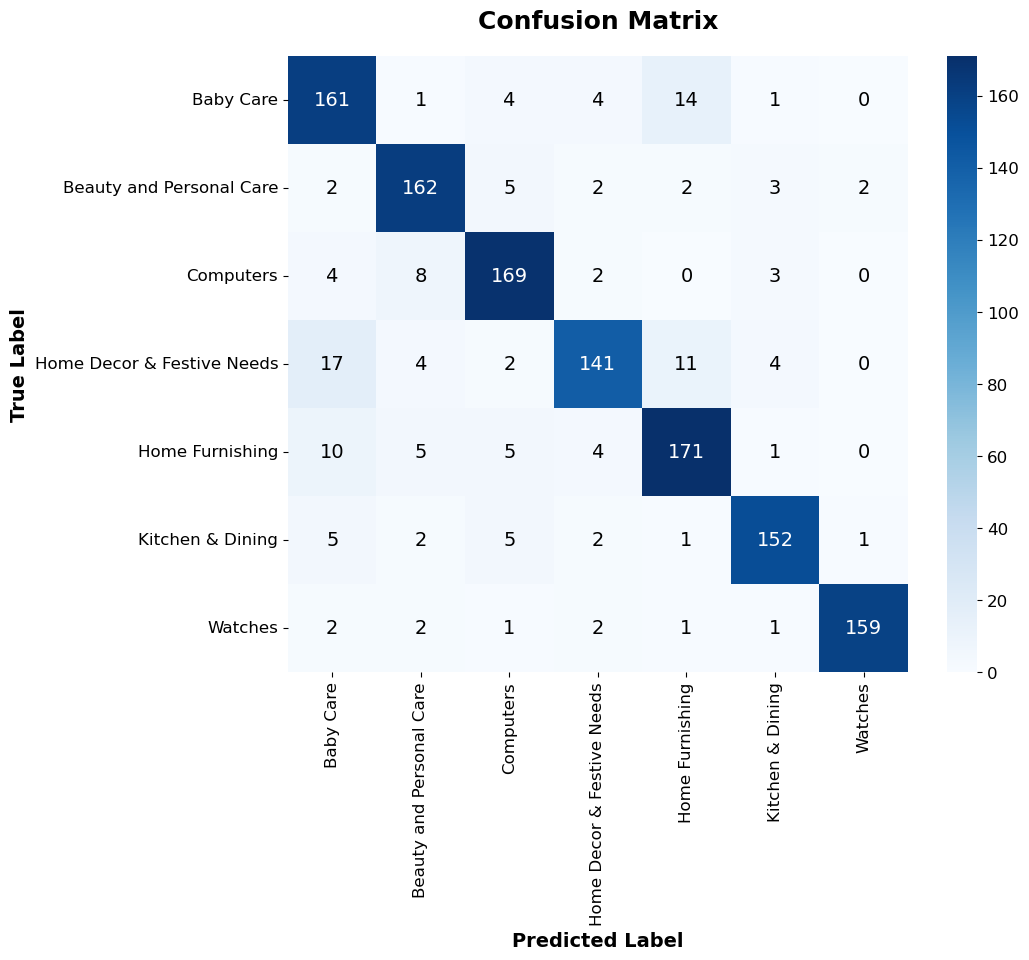

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred), yticklabels=np.unique(y_test))
# Add annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        color = 'white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black'
        plt.text(j + 0.5, i + 0.5, conf_matrix[i, j], ha='center', va='center', color=color, fontsize=14)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

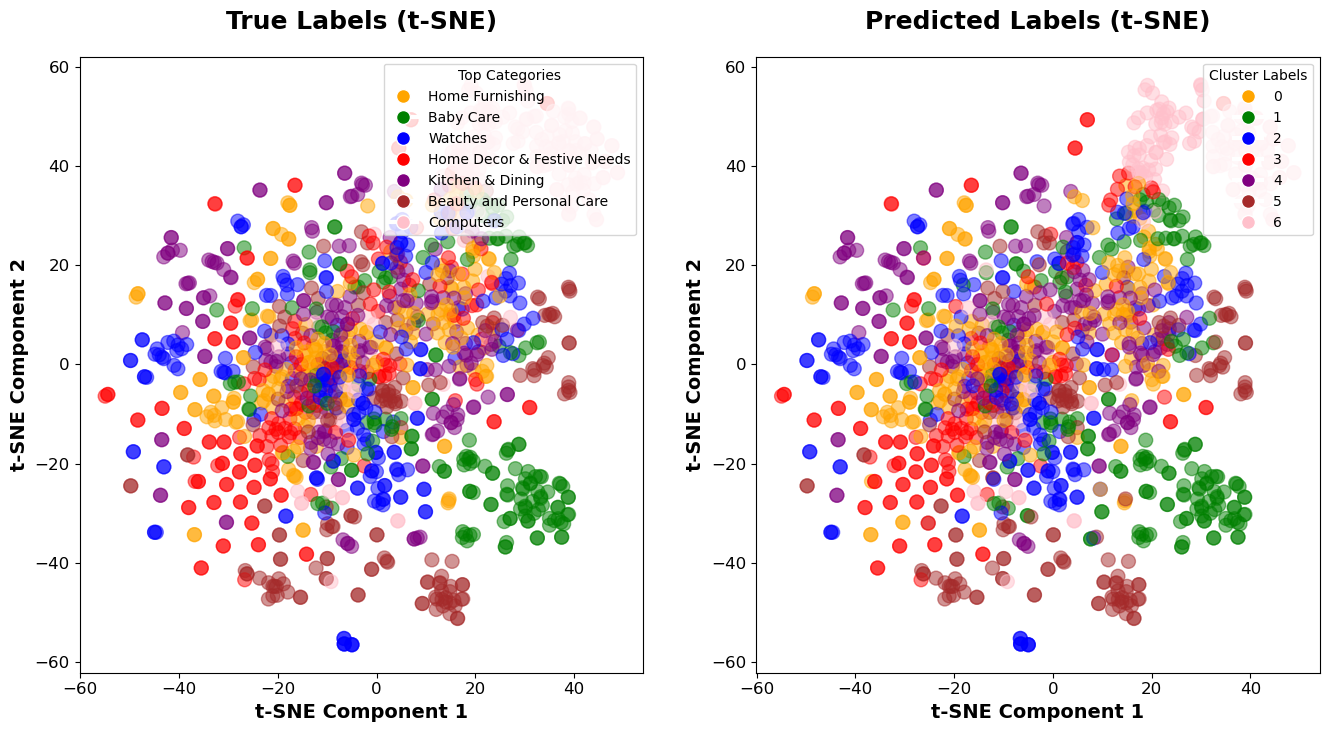

In [12]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the string labels to numerical values for y_test and y_pred
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred)

# Extract unique top categories from df_data_augmented
top_categories = df_data_augmented['top_category'].unique()

# Define a dictionary to map encoded labels to their corresponding string values
label_mapping = {idx: category for idx, category in enumerate(top_categories)}

# Define colors for each unique top category manually
top_category_color_dict = {
    'Home Furnishing': 'orange',               # Orange
    'Baby Care': 'green',                      # Green
    'Watches': 'blue',                         # Blue
    'Home Decor & Festive Needs': 'red',       # Red
    'Kitchen & Dining': 'purple',              # Purple
    'Beauty and Personal Care': 'brown',       # Brown
    'Computers': 'pink'                        # Pink
}

# Apply t-SNE to the features
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(X_test_flat)

# Define the figure and axis objects
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot true labels in t-SNE space with top category legend
legend1_handles = []
for label in np.unique(y_test_encoded):
    category = label_mapping[label]
    color = top_category_color_dict.get(category, 'black')  # Use black as default if category not found in dict
    legend1_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

scatter1 = axes[0].scatter(features_tsne[:, 0], features_tsne[:, 1], label='True Labels', marker='o', alpha=0.5)
axes[0].set_title('True Labels (t-SNE)')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
legend1 = axes[0].legend(handles=legend1_handles, title='Top Categories', loc='upper right')

# Set colors of the points in scatter plot based on y_test_encoded
colors = [top_category_color_dict[label_mapping[label]] for label in y_test_encoded]
scatter1.set_facecolor(colors)












from collections import Counter

# Create a mapping between true category and cluster category
cluster_mapping = {}
for true_label, cluster_label in zip(y_test_encoded, y_pred_encoded):
    if cluster_label not in cluster_mapping:
        cluster_mapping[cluster_label] = Counter()
    cluster_mapping[cluster_label][true_label] += 1

# Determine the majority true category for each cluster
majority_true_categories = {}
for cluster_label, counter in cluster_mapping.items():
    majority_true_categories[cluster_label] = counter.most_common(1)[0][0]

# Map cluster categories to true categories
cluster_category_to_true_category = {cluster_label: label_mapping[true_label] for cluster_label, true_label in majority_true_categories.items()}

# Get colors for each cluster based on the true categories
cluster_colors = [top_category_color_dict[cluster_category_to_true_category[cluster_label]] for cluster_label in y_pred_encoded]




# Get unique true labels and their corresponding colors
unique_true_labels = np.unique(y_test_encoded)
true_label_colors = [top_category_color_dict[label_mapping[label]] for label in unique_true_labels]

# Define legend handles for predicted labels plot
legend2_handles = []
for label, color in zip(unique_true_labels, true_label_colors):
    legend2_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))

# Plot predicted labels in t-SNE space with legend
scatter2 = axes[1].scatter(features_tsne[:, 0], features_tsne[:, 1], c=cluster_colors, label='Predicted Labels', marker='o', alpha=0.5)
axes[1].set_title('Predicted Labels (t-SNE)')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
legend2 = axes[1].legend(handles=legend2_handles, title='Cluster Labels', loc='upper right')

In [ ]:
# # ==================================================================================================
# # LEARNING CURVES
# # OVERFITTING ?
# # ==================================================================================================
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import learning_curve

# # Perform cross-validation
# cv_scores = cross_val_score(rf_classifier, X_train_flat, y_train, cv=5)
# print("Cross-Validation Scores:", cv_scores)
# print("Mean CV Score:", np.mean(cv_scores))

# # Plot learning curves
# train_sizes, train_scores, valid_scores = learning_curve(rf_classifier, X_train_flat, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
# plt.plot(train_sizes, np.mean(valid_scores, axis=1), label='Validation Score')
# plt.xlabel('Training Set Size')
# plt.ylabel('Accuracy')
# plt.title('Learning Curves')
# plt.legend()
# plt.grid(True)
# plt.show()


In [13]:
# ==================================================================================================
# CNN WITH SVM CLASSIFIER
# ==================================================================================================
# Now 'features' contains the extracted features for each image
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, image_labels, test_size=0.2, random_state=42)

# Flatten the feature vectors
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train a classifier (e.g., SVM) on extracted features
from sklearn.svm import SVC
svm_classifier = SVC()
svm_classifier.fit(X_train_flat, y_train)

# Predict labels for test data
y_pred = svm_classifier.predict(X_test_flat)

# Evaluate classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate Adjusted Rand Index
ari = adjusted_rand_score(y_test, y_pred)
print("Adjusted Rand Index:", ari)

results_list.append({'Classifieur': 'SVM - Data Augmented', 'ARI': ari, 'Best Accuracy': accuracy})
df_results = pd.DataFrame(results_list) # Convert the list of dictionaries to a DataFrame

Accuracy: 0.9111111111111111
Adjusted Rand Index: 0.8035690055245356


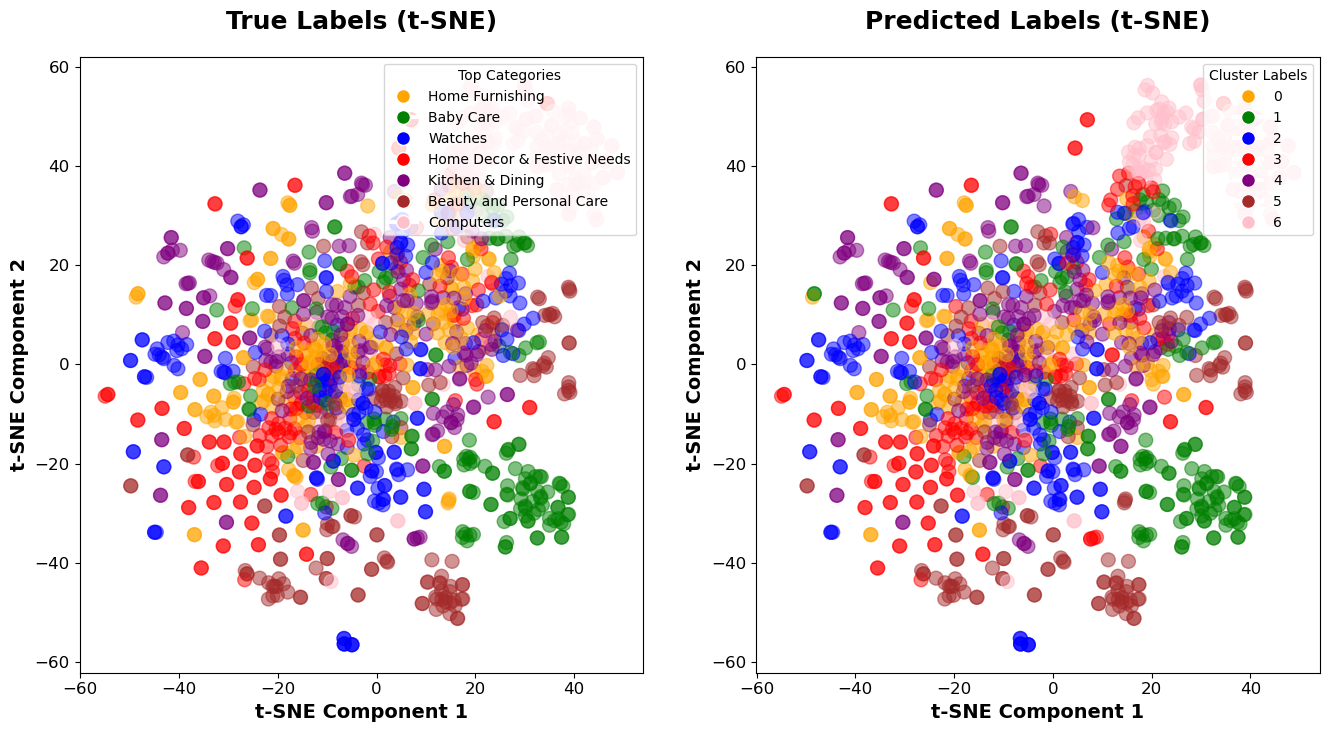

In [14]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the string labels to numerical values for y_test and y_pred
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred)

# Extract unique top categories from df_data_augmented
top_categories = df_data_augmented['top_category'].unique()

# Define a dictionary to map encoded labels to their corresponding string values
label_mapping = {idx: category for idx, category in enumerate(top_categories)}

# Define colors for each unique top category manually
top_category_color_dict = {
    'Home Furnishing': 'orange',               # Orange
    'Baby Care': 'green',                      # Green
    'Watches': 'blue',                         # Blue
    'Home Decor & Festive Needs': 'red',       # Red
    'Kitchen & Dining': 'purple',              # Purple
    'Beauty and Personal Care': 'brown',       # Brown
    'Computers': 'pink'                        # Pink
}

# Apply t-SNE to the features
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(X_test_flat)

# Define the figure and axis objects
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot true labels in t-SNE space with top category legend
legend1_handles = []
for label in np.unique(y_test_encoded):
    category = label_mapping[label]
    color = top_category_color_dict.get(category, 'black')  # Use black as default if category not found in dict
    legend1_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

scatter1 = axes[0].scatter(features_tsne[:, 0], features_tsne[:, 1], label='True Labels', marker='o', alpha=0.5)
axes[0].set_title('True Labels (t-SNE)')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
legend1 = axes[0].legend(handles=legend1_handles, title='Top Categories', loc='upper right')

# Set colors of the points in scatter plot based on y_test_encoded
colors = [top_category_color_dict[label_mapping[label]] for label in y_test_encoded]
scatter1.set_facecolor(colors)












from collections import Counter

# Create a mapping between true category and cluster category
cluster_mapping = {}
for true_label, cluster_label in zip(y_test_encoded, y_pred_encoded):
    if cluster_label not in cluster_mapping:
        cluster_mapping[cluster_label] = Counter()
    cluster_mapping[cluster_label][true_label] += 1

# Determine the majority true category for each cluster
majority_true_categories = {}
for cluster_label, counter in cluster_mapping.items():
    majority_true_categories[cluster_label] = counter.most_common(1)[0][0]

# Map cluster categories to true categories
cluster_category_to_true_category = {cluster_label: label_mapping[true_label] for cluster_label, true_label in majority_true_categories.items()}

# Get colors for each cluster based on the true categories
cluster_colors = [top_category_color_dict[cluster_category_to_true_category[cluster_label]] for cluster_label in y_pred_encoded]




# Get unique true labels and their corresponding colors
unique_true_labels = np.unique(y_test_encoded)
true_label_colors = [top_category_color_dict[label_mapping[label]] for label in unique_true_labels]

# Define legend handles for predicted labels plot
legend2_handles = []
for label, color in zip(unique_true_labels, true_label_colors):
    legend2_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10))

# Plot predicted labels in t-SNE space with legend
scatter2 = axes[1].scatter(features_tsne[:, 0], features_tsne[:, 1], c=cluster_colors, label='Predicted Labels', marker='o', alpha=0.5)
axes[1].set_title('Predicted Labels (t-SNE)')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
legend2 = axes[1].legend(handles=legend2_handles, title='Cluster Labels', loc='upper right')

In [15]:
# ==================================================================================================
# CNN WITH KMEANS CLASSIFIER
# ==================================================================================================
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, adjusted_rand_score
from collections import Counter

# Train KMeans on extracted features
kmeans = KMeans(n_clusters=unique_categories_selected)  # Specify the number of clusters
cluster_labels = kmeans.fit_predict(features.reshape(features.shape[0], -1))
y_pred = cluster_labels

# Count the occurrences of each cluster label
cluster_counts = Counter(cluster_labels)
# Print the count for each cluster
for label, count in cluster_counts.items():
    print(f"Cluster {label}: {count} samples")
    
# Create a mapping from cluster labels to true labels based on majority voting
cluster_to_label = {}
for cluster_label in np.unique(cluster_labels):
    cluster_indices = np.where(cluster_labels == cluster_label)[0]  # Get indices of data points in this cluster
    true_labels_in_cluster = [image_labels[i] for i in cluster_indices]  # Get true labels of data points in this cluster
    most_common_label = Counter(true_labels_in_cluster).most_common(1)[0][0]  # Find the most common true label
    cluster_to_label[cluster_label] = most_common_label


# Map cluster predictions to corresponding true labels
predicted_labels = [cluster_to_label[cluster_label] for cluster_label in cluster_labels]

# Evaluate clustering accuracy using labels
accuracy = accuracy_score(image_labels, predicted_labels)
print("Accuracy:", accuracy)

# Calculate Adjusted Rand Index
ari = adjusted_rand_score(image_labels, predicted_labels)
print("Adjusted Rand Index:", ari)

results_list.append({'Classifieur': 'KMEANS - Data Augmented', 'ARI': ari, 'Best Accuracy': accuracy})
df_results = pd.DataFrame(results_list) # Convert the list of dictionaries to a DataFrame

Cluster 3: 2700 samples
Cluster 4: 1468 samples
Cluster 6: 547 samples
Cluster 0: 622 samples
Cluster 2: 293 samples
Cluster 1: 306 samples
Cluster 5: 364 samples
Accuracy: 0.3523809523809524
Adjusted Rand Index: 0.10932131006851091


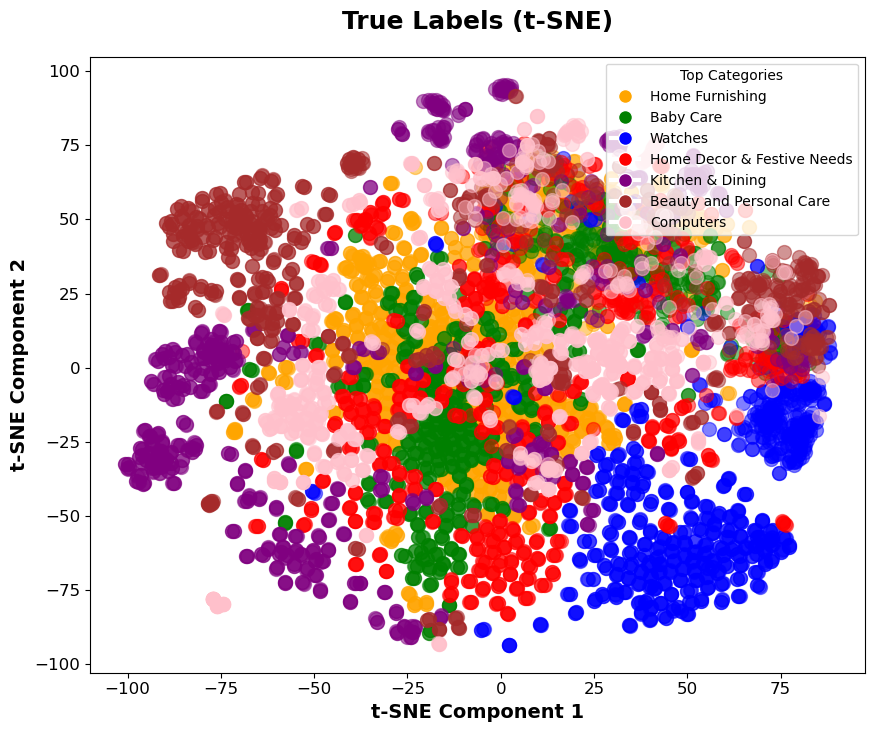

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE to the features for visualization
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features.reshape(features.shape[0], -1))

# Define colors using the specified top_category_color_dict
top_category_color_dict = {
    'Home Furnishing': 'orange',
    'Baby Care': 'green',
    'Watches': 'blue',
    'Home Decor & Festive Needs': 'red',
    'Kitchen & Dining': 'purple',
    'Beauty and Personal Care': 'brown',
    'Computers': 'pink'
}

# Map image labels to their corresponding colors using the top_category_color_dict
true_label_colors = [top_category_color_dict[label] for label in image_labels]

# Create custom legend handles and labels
legend_handles = []
for category, color in top_category_color_dict.items():
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

plt.figure(figsize=(10, 8))
for idx, color in enumerate(true_label_colors):
    plt.scatter(features_tsne[idx, 0], features_tsne[idx, 1], color=color, alpha=0.5)

plt.title('True Labels (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(handles=legend_handles, title='Top Categories', loc='upper right')
plt.show()


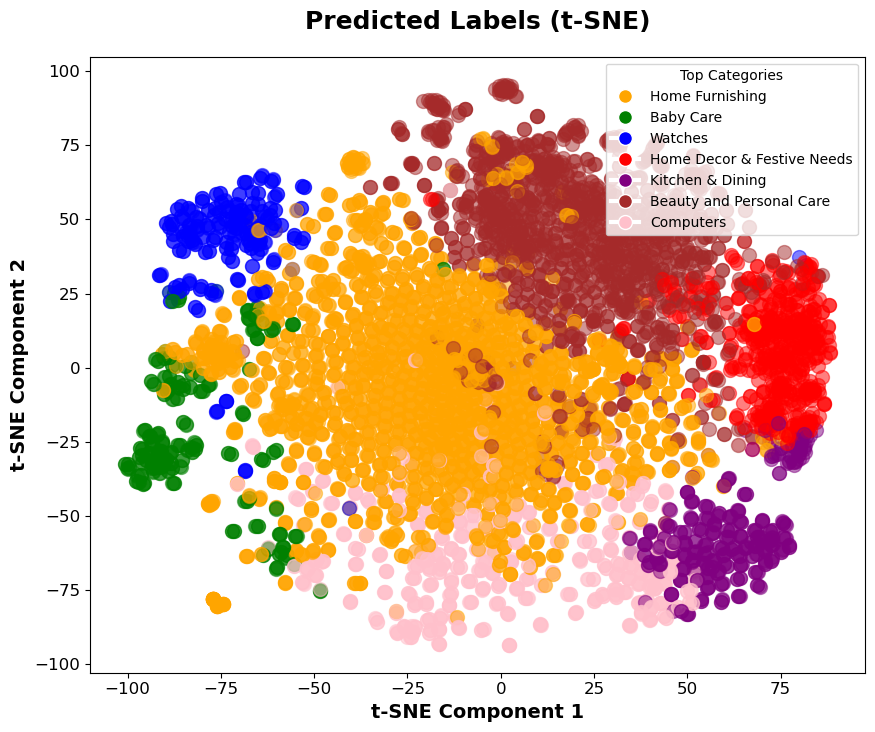

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE to the features for visualization
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features.reshape(features.shape[0], -1))

# Define colors using the specified top_category_color_dict
top_category_color_dict = {
    'Home Furnishing': 'orange',
    'Baby Care': 'green',
    'Watches': 'blue',
    'Home Decor & Festive Needs': 'red',
    'Kitchen & Dining': 'purple',
    'Beauty and Personal Care': 'brown',
    'Computers': 'pink'
}

# Define a mapping between numeric cluster labels and categories
numeric_to_category = {
    0: 'Computers',
    1: 'Watches',
    2: 'Baby Care',
    3: 'Home Furnishing',
    4: 'Beauty and Personal Care',
    5: 'Kitchen & Dining',
    6: 'Home Decor & Festive Needs'
}

# Map numeric cluster labels to categories
cluster_categories = [numeric_to_category[label] for label in cluster_labels]

# Map cluster categories to their corresponding colors using the top_category_color_dict
cluster_colors = [top_category_color_dict[category] for category in cluster_categories]

# Create custom legend handles and labels
legend_handles = []
for category, color in top_category_color_dict.items():
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=10))

plt.figure(figsize=(10, 8))
for idx, color in enumerate(cluster_colors):
    plt.scatter(features_tsne[idx, 0], features_tsne[idx, 1], color=color, alpha=0.5)

plt.title('Predicted Labels (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(handles=legend_handles, title='Top Categories', loc='upper right')
plt.show()


## II.1. RESULTS

In [18]:
display(df_results)

,Classifieur,ARI,Best Accuracy
0,Random Forest - Data Augmented,0.75,0.88
1,SVM - Data Augmented,0.80,0.91
2,KMEANS - Data Augmented,0.11,0.35
